## Aquisition de l'image

In [1]:
%matplotlib widget
import subprocess
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
imageBacATomate1 = 'images/bacATomates.jpg'
imageBacATomate2 = 'images/bacATomates2.jpg'

In [4]:
subprocess.run('fswebcam --device /dev/video0 -r 1280x720 --no-banner ' + imageBacATomate1, shell=True)
subprocess.run('fswebcam --device /dev/video2 -r 1280x720 --no-banner ' + imageBacATomate2, shell=True)

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to 'images/bacATomates.jpg'.
--- Opening /dev/video2...
Trying source module v4l2...
/dev/video2 opened.
No input was specified, using the first.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to 'images/bacATomates2.jpg'.


CompletedProcess(args='fswebcam --device /dev/video2 -r 1280x720 --no-banner images/bacATomates2.jpg', returncode=0)

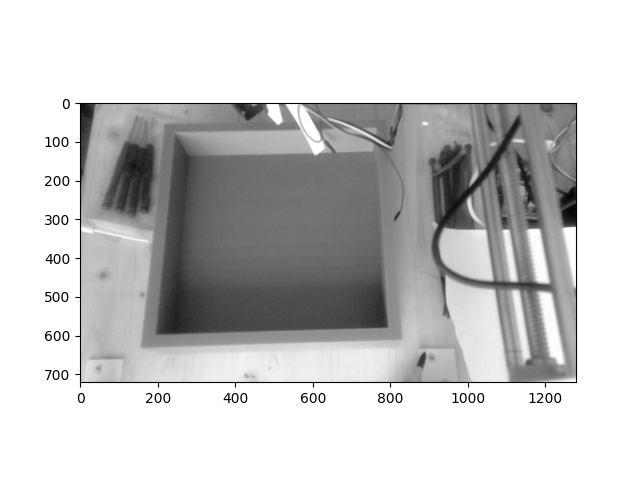

In [5]:
img = cv2.imread(imageBacATomate1, 0) 
plt.figure()
plt.imshow(img, cmap='gray')
plt.show()

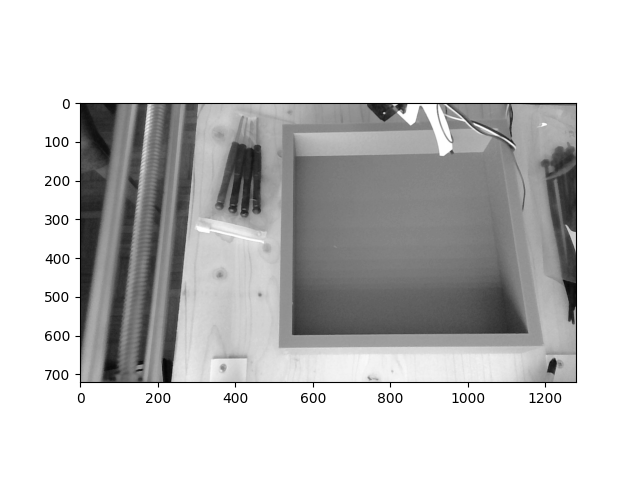

In [6]:
img = cv2.imread(imageBacATomate2, 0) 
plt.figure()
plt.imshow(img, cmap='gray')
plt.show()

# Calibration de la caméra

Les caméras peuvent être calibrées en analysant une image contenant un objet dont les dimensions sont connues. Le but serait de calibrer les caméras en analysant les images du récipient à tomates.

## Modèle mathématique de projection des points 3D sur la caméra
### Paramètres intrisèques de la caméra
Les paramètres intrisèques représentent les paramètres de projections des points 3D sur l'écran de la caméra. On prend comme origine le référentiel de la caméra et on cherche une relation entre les réels points 3D de l'objet et les pixels vus sur l'écran de la caméra. Nous cherchons donc un modèle mathématique permettant de passer d'une coordonnée réel X, Y, Z à sa coordonnée correspondante en pixels sur l'écran de la caméra. Nous dénotons X, Y, Z les coordonnées de l'objet vu depuis le référentiel de la caméra, et Xe, Ye les coordonnées correspondantes en pixels sur l'écran de la caméra. La distance entre le référenciel de la caméra et son écran correspond à la focale de la caméra, notée f. L'échelle utilisée ici sera le mm.
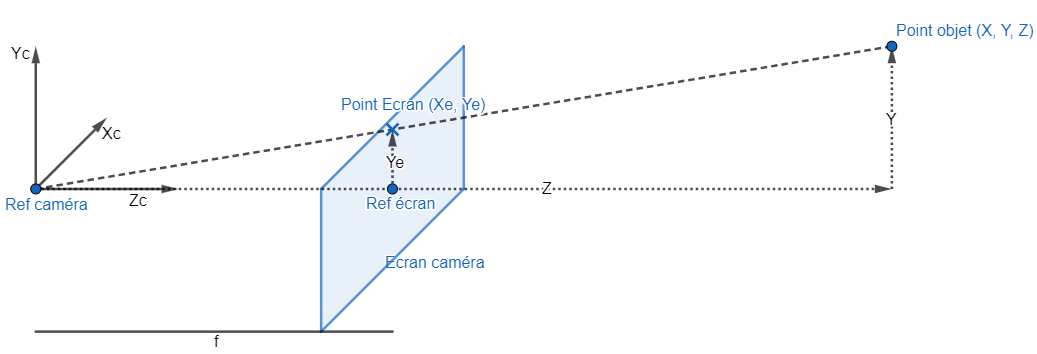
D'après l'image ci-dessus, nous pouvons extraire les 2 équations suivantes : 
$$X_e = X \frac{f}{Z}$$
$$Y_e = Y \frac{f}{Z}$$
Lorsque nous travaillons avec une image, nous apprécions avoir des coordonnées en pixels et non en mm. Nous allons donc ajouter dans ces équations les paramètres $p_x$ et $p_y$ qui correspondent à la densité de pixels selon x et z. ($p_x$ correspond au nombre de pixels en x par mm, et $p_y$ au nombre de pixels en y par mm). Leur unité est des pixels / mm. Voic les 2 nouvelles équations dans lesquels Xe et Ye correspondent au cordonnées de l'image en pixels : 
$$X_e = X \cdot p_x \frac{f}{Z}$$
$$Y_e = Y \cdot p_y \frac{f}{Z}$$
L'axe optique de la caméra n'est pas forcément aligné (ou parfaitement aligné) avec le centre de l'écran, et il peut donc y avoir (volontairement ou non) un décalage entre l'axe optique et l'origine de l'écran. Nous pouvons donc inclure 2 nouveaux paramètres $\sigma_x$ et $\sigma_y$ qui correspondent au décalage respectif de l'axe optique selon l'axe X et Y de l'écran. (Ce décalage est en pixels.)
$$X_e = X \cdot p_x \frac{f}{Z} - \sigma_x$$
$$Y_e = Y \cdot p_y \frac{f}{Z} - \sigma_y$$
Et par habitude en traitement d'image, on considère l'origine (0, 0) en haut à gauche de l'image. Nous pouvons donc inclure une dernière transformation pour que nos coordonnées (Xe, Ye) soient centrées en haut à gauche de l'image. Notons $P_x$ et $P_y$ le nombre de pixels total de la caméra en X et en Y. Nos 2 équations deviennent les suivantes : 
$$X_e = X \cdot p_x \frac{f}{Z} - \sigma_x - \frac{P_x}{2}$$
$$Y_e = - (Y \cdot p_y \frac{f}{Z} - \sigma_y) - \frac{P_y}{2} = -Y \cdot p_y \frac{f}{Z} + \sigma_y - \frac{P_y}{2}$$
Nous obtenons donc 2 équations de la forme
$$X_e = f_{xe} \frac{X}{Z} + d_{xe}$$
$$Y_e = f_{ye} \frac{Y}{Z} + d_{ye}$$
Avec 
$$f_{xe} = p_x \cdot f$$
$$f_{ye} = - p_y \cdot f$$
$$d_{xe} = - \sigma_x - \frac{P_x}{2}$$
$$d_{ye} = \sigma_y - \frac{P_y}{2}$$
Pour passer des coordonnées du monde (X, Y, Z) aux coordonnées en pixels (Xe, Ye), il faudra donc trouver les 4 paramètres $f_{xe}$, $f_{ye}$, $d_{xe}$, $d_{ye}$. Une fois ces paramètres intrinsèques déterminés, nous pourrons utiliser les équations suivantes pour relier les coordonnées du monde en mm en pixels sur la caméra: 
$$X_e = f_{xe} \frac{X}{Z} + d_{xe}$$
$$Y_e = f_{ye} \frac{Y}{Z} + d_{ye}$$
En multipliant par Z, nous obtenons
$$X_e \cdot Z = f_{xe} \cdot X + d_{xe} \cdot Z$$
$$Y_e \cdot Z = f_{ye} \cdot Y + d_{ye} \cdot Z$$
Nous pouvons écrire ce système d'équation sous forme matricielle en passant en coordonnées homogènes (le facteur d'échelle sera Z). Nous ajoutons alors une 3ème dimension au vecteur $\begin{pmatrix} X_e \\ Y_e \end{pmatrix}$ de sorte que $\begin{pmatrix} X_e \\ Y_e \\ 1 \end{pmatrix}$ = $\begin{pmatrix} X_e \cdot Z \\ Y_e \cdot Z \\ Z \end{pmatrix}$. Nous pouvons alors re-écrire les équations sous la forme matricielle suivante :
$$\begin{pmatrix} X_e \cdot Z \\ Y_e \cdot Z \\ Z \end{pmatrix} = \begin{pmatrix} f_{xe} & 0 & d_{xe} \\ 0 & f_{ye} & d_{ye} \\ 0 & 0 & 1 \end{pmatrix} \cdot \begin{pmatrix} X \\ Y \\ Z \end{pmatrix}$$
Ce qui correspond au système suivant.
$$\begin{pmatrix} X_e \\ Y_e \\ 1 \end{pmatrix} = \begin{pmatrix} f_{xe} & 0 & d_{xe} \\ 0 & f_{ye} & d_{ye} \\ 0 & 0 & 1 \end{pmatrix} \cdot \begin{pmatrix} X \\ Y \\ Z \end{pmatrix}$$

### Paramètres extrinsèques de la caméra
Il est très souvent plus pratique d'utiliser un autre référentiel que celui de la caméra pour décrire les points 3D réels de l'objets. Les coordonnées du monde seront donc décrites dans le référentiel de ce monde plutôt que dans celui de la caméra. Les paramètres extrinsèques représentent les paramètres permettant de passer mathématiquement du référentiel monde au référentiel caméra. Le passage du référentiel du monde à celui de la caméra sera forcément la combinaison d'une rotation et d'une translation. Une transformation contenant une rotation et une translation peut s'écrire sous la forme matricielle suivante (où Xm, Ym, Zm sont les coordonnées dans le référentiel du monde, et Xc, Yc, Zc sont les coordonnées dans le référentiel de la caméra) : 
$$\begin{pmatrix} X_c \\ Y_c \\ Z_c \end{pmatrix} = \begin{pmatrix} r_{11} & r_{12} & r_{13} & t_x \\ r_{21} & r_{22} & r_{23} & t_y \\ r_{31} & r_{32} & r_{33} & t_z \end{pmatrix} \cdot \begin{pmatrix} X_m \\ Y_m \\ Z_m \\ 1 \end{pmatrix}$$
### Modèle mathématique complet
Nous cherchons maintenant le modèle complet qui va nous donner directement les coordonnées des pixels de la caméra par rapport à un point de l'objet dans les coordonnées du monde. Comme décrit ci-dessus, le modèle extrinsèque nous donne une relation entre les coordonnées de l'objet dans le référentiel du monde en coordonnées dans le référentiel de la caméra (passage de (Xm, Ym, Zm) en (Xc, Yc, Zc)). Quant au modèle intrinsèque, il nous donne une relation entre les coordonnées dans le référentiel de la caméra et les coordonnées 2D en pixels sur l'écran de la caméra (passage de (Xc, Yc, Zc) en (Xe, Ye)).
$$ \text{Modèle intrinsèque :} \begin{pmatrix} X_e \\ Y_e \\ 1 \end{pmatrix} = \begin{pmatrix} f_{xe} & 0 & d_{xe} \\ 0 & f_{ye} & d_{ye} \\ 0 & 0 & 1 \end{pmatrix} \cdot \begin{pmatrix} X_c \\ Y_c \\ Z_c \end{pmatrix}$$
$$ \text{Modèle extrinsèque :} \begin{pmatrix} X_c \\ Y_c \\ Z_c \end{pmatrix} = \begin{pmatrix} r_{11} & r_{12} & r_{13} & t_x \\ r_{21} & r_{22} & r_{23} & t_y \\ r_{31} & r_{32} & r_{33} & t_z \end{pmatrix} \cdot \begin{pmatrix} X_m \\ Y_m \\ Z_m \\ 1 \end{pmatrix}$$
En combinant ces 2 modèles, nous obtenons : 
$$\begin{pmatrix} X_e \\ Y_e \\ 1 \end{pmatrix} = \begin{pmatrix} f_{xe} & 0 & d_{xe} \\ 0 & f_{ye} & d_{ye} \\ 0 & 0 & 1 \end{pmatrix} \cdot \begin{pmatrix} r_{11} & r_{12} & r_{13} & t_x \\ r_{21} & r_{22} & r_{23} & t_y \\ r_{31} & r_{32} & r_{33} & t_z \end{pmatrix} \cdot \begin{pmatrix} X_m \\ Y_m \\ Z_m \\ 1 \end{pmatrix}$$
Le modèle mathématique complet sera donc sous la forme 
$$\begin{pmatrix} X_e \\ Y_e \\ 1 \end{pmatrix} = \begin{pmatrix} p_{11} & p_{12} & p_{13} & p_{14} \\ p_{21} & p_{22} & p_{23} & p_{24} \\ p_{31} & p_{32} & p_{33} & p_{34} \end{pmatrix} \cdot \begin{pmatrix} X_m \\ Y_m \\ Z_m \\ 1 \end{pmatrix}$$


## Calibrage de la caméra
Le calibrage de la caméra consiste à trouver la matrice de projection complète (lié au passage de (Xm, Ym, Zm) en (Xe, Ye)). Il faudra donc trouver la matrice du modèle mathématique complet :
$$\begin{pmatrix} X_e \\ Y_e \\ 1 \end{pmatrix} = \begin{pmatrix} p_{11} & p_{12} & p_{13} & p_{14} \\ p_{21} & p_{22} & p_{23} & p_{24} \\ p_{31} & p_{32} & p_{33} & p_{34} \end{pmatrix} \cdot \begin{pmatrix} X_m \\ Y_m \\ Z_m \\ 1 \end{pmatrix}$$
En ayant une seule observation, le système peut s'écrire : 
$$\begin{pmatrix} X_e^1 \\ Y_e^1 \\ 1 \end{pmatrix} = \begin{pmatrix} X_m^1 & Y_m^1 & Z_m^1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & X_m^1 & Y_m^1 & Z_m^1 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & X_m^1 & Y_m^1 & Z_m^1 & 1 \end{pmatrix} \cdot \begin{pmatrix} p_{11} \\ p_{12} \\ p_{13} \\ p_{14} \\ p_{21} \\ p_{22} \\ p_{23} \\ p_{24} \\p_{31} \\ p_{32} \\ p_{33} \\ p_{34} \end{pmatrix}$$
Et en ayant n observations, le système s'écrit : 
$$\begin{pmatrix} X_e^1 \\ ... \\ X_e^n \\ Y_e^1 \\ ... \\ Y_e^n \\ 1 \\ ... \\ 1 \end{pmatrix} = \begin{pmatrix} X_m^1 & Y_m^1 & Z_m^1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ ... & ... & ... & ... & ... & ... & ... & ... & ... & ... & ... & ... \\ X_m^n & Y_m^n & Z_m^n & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & X_m^1 & Y_m^1 & Z_m^1 & 1 & 0 & 0 & 0 & 0 \\ ... & ... & ... & ... & ... & ... & ... & ... & ... & ... & ... & ... \\ 0 & 0 & 0 & 0 & X_m^n & Y_m^n & Z_m^n & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & X_m^1 & Y_m^1 & Z_m^1 & 1 \\ ... & ... & ... & ... & ... & ... & ... & ... & ... & ... & ... & ... \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & X_m^n & Y_m^n & Z_m^n & 1 \end{pmatrix} \cdot \begin{pmatrix} p_{11} \\ p_{12} \\ p_{13} \\ p_{14} \\ p_{21} \\ p_{22} \\ p_{23} \\ p_{24} \\p_{31} \\ p_{32} \\ p_{33} \\ p_{34} \end{pmatrix}$$
Ce système est de la forme Ax = b, avec la matrice A et le vecteur b connus. Pour calibrer au mieux la caméra, nous allons chercher le vecteur x (vecteur contenant les paramètres $p_{11}$, ... , $p_{34}$) qui minimise le carré des erreurs (solution des moindre carrés).
Ce vecteur optimal est obtenu en résolvant le système : $A^\intercal A x = A^\intercal b$. Le vecteur x (vecteur contenant les paramètres $p_{11}$, ... , $p_{34}$) se calcul alors comme ceci : $x = (A^\intercal A)^{-1} A^\intercal b$

In [5]:
nbPointsRef = 8
Xe = np.zeros([2, nbPointsRef])
Xm = np.zeros([3, nbPointsRef])
# Collecte des 8 points de référence avec leur image
Xe = np.random.randint(10, size=(2, nbPointsRef))
Xm = np.random.randint(10, size=(3, nbPointsRef))
print(Xe)
print(Xm)

[[1 4 4 8 1 6 8 5]
 [3 4 5 7 4 2 3 4]]
[[5 9 3 5 2 9 7 1]
 [4 0 0 8 6 3 0 1]
 [3 6 5 6 1 4 0 1]]


In [6]:
# Transformation des 8 points de références et leur image en vecteur b et matrice A
# Vecteur b
b = np.ones([nbPointsRef * 3, 1])
b[0:nbPointsRef, 0] = Xe[0, :]
b[nbPointsRef:2 * nbPointsRef, 0] = Xe[1, :]

# Matrice A
A = np.zeros([3 * nbPointsRef, 12])

A[0:nbPointsRef, 0] = Xm[0, :]
A[0:nbPointsRef, 1] = Xm[1, :]
A[0:nbPointsRef, 2] = Xm[2, :]
A[0:nbPointsRef, 3] = np.ones([nbPointsRef])

A[nbPointsRef:2*nbPointsRef, 4] = Xm[0, :]
A[nbPointsRef:2*nbPointsRef, 5] = Xm[1, :]
A[nbPointsRef:2*nbPointsRef, 6] = Xm[2, :]
A[nbPointsRef:2*nbPointsRef, 7] = np.ones([nbPointsRef])

A[2*nbPointsRef:3*nbPointsRef, 8] = Xm[0, :]
A[2*nbPointsRef:3*nbPointsRef, 9] = Xm[1, :]
A[2*nbPointsRef:3*nbPointsRef, 10] = Xm[2, :]
A[2*nbPointsRef:3*nbPointsRef, 11] = np.ones([nbPointsRef])

print(b)
print(A)

[[1.]
 [4.]
 [4.]
 [8.]
 [1.]
 [6.]
 [8.]
 [5.]
 [3.]
 [4.]
 [5.]
 [7.]
 [4.]
 [2.]
 [3.]
 [4.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[5. 4. 3. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [9. 0. 6. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 0. 5. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 8. 6. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 6. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [9. 3. 4. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [7. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 5. 4. 3. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 9. 0. 6. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0. 5. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 5. 8. 6. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 6. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 9. 3. 4. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 7. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 5. 4. 3. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 9. 0. 6. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 5. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 5. 8. 6. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 6. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 9. 3. 4. 1

In [7]:
# Calcul du vecteur optimal x contenant les p11, ..., p34
At = np.transpose(A)
x = np.matmul(np.matmul(np.linalg.inv(np.matmul(At, A)), At), b)
print(x)

[[ 3.25994615e-01]
 [-4.26037530e-03]
 [-4.19352108e-02]
 [ 3.10228307e+00]
 [-2.95197882e-01]
 [ 1.06916152e-01]
 [ 4.31095874e-01]
 [ 3.81780814e+00]
 [ 1.11022302e-16]
 [-9.02056208e-17]
 [ 8.67361738e-17]
 [ 1.00000000e+00]]


In [8]:
# Réarrangement des valeurs du vecteur x en matrice p (4 x 3)
P = np.zeros([3, 4])
P[0, :] = x[0:4, 0]
P[1, :] = x[4:8, 0]
P[2, :] = x[8:12, 0]
print(P)

[[ 3.25994615e-01 -4.26037530e-03 -4.19352108e-02  3.10228307e+00]
 [-2.95197882e-01  1.06916152e-01  4.31095874e-01  3.81780814e+00]
 [ 1.11022302e-16 -9.02056208e-17  8.67361738e-17  1.00000000e+00]]


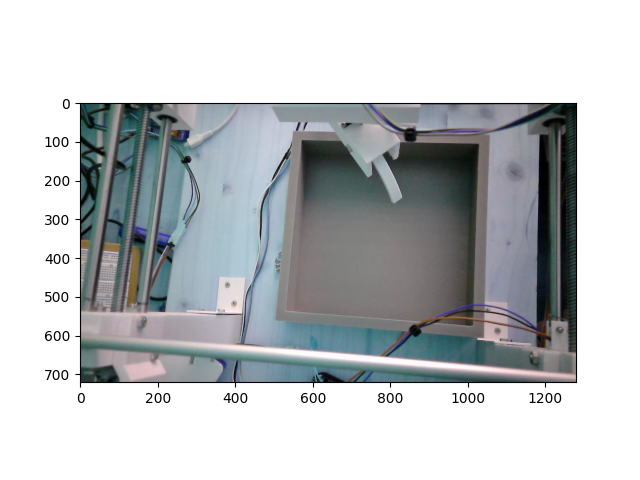

(720, 1280, 3)

In [9]:
imageCalibration = 'images/testCalibration.jpg'
imgCal = cv2.imread(imageCalibration, 1) 
plt.figure()
plt.imshow(imgCal, cmap='gray')
plt.show()
imgCal.shape

Les différences en pixels entre le bac à tomate et le reste semblent plus marquées sur la couleur rouge. Essayons donc d'extraire le bac à tomate avec un algorithme de region growing basé sur la couleur rouge. Voici l'histogramme des pixels par rapport à la couleur rouge

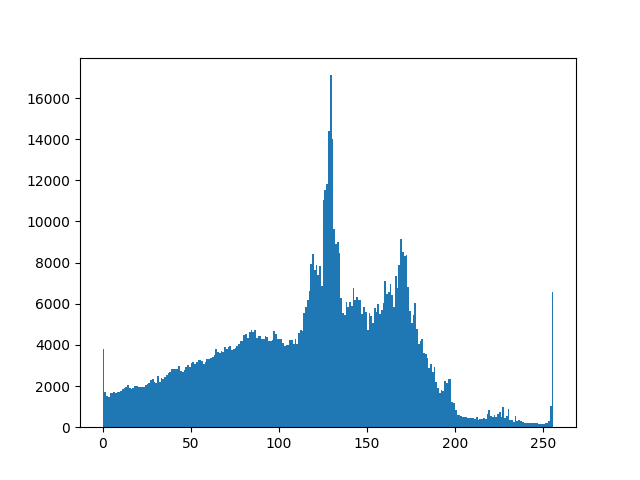

In [14]:
imgCalRed = imgCal[:, :, 0]
plt.figure()
plt.hist(imgCalRed.ravel(), bins=256, range=(0, 256))
plt.show()

La valeur d'intensité 129 pour le rouge est la plus représentée dans l'image et correspond à la couleur du bac à tomates. Pour démarrer le region growing, nous allons nous baser sur un pixel d'intensité 129. Et pour réduire encore le risque d'erreur, nous allons chercher un tel pixel en partant du centre de l'image (puisque le bac à tomate est relativement centré sur l'image).
Le point de démarrage de l'algorithme sera donc le premier pixel de valeur 129 trouvé en cherchant depuis le centre de l'image.

In [13]:
xMiddle = 640
yMiddle = 360
intensityToSearch = 129
xStart = xMiddle
yStart = yMiddle
while(imgCalRed[xStart, yStart] != intensityToSearch) :
    

In [ ]:
kernelVerticalEdge = np.array([[-1, 0, 1],
                    [-1, 0, 1],
                    [-1, 0, 1]])
verticalEdge = cv2.filter2D(src=imgCal, ddepth=-1, kernel=kernelVerticalEdge)
plt.figure()
plt.imshow(verticalEdge, cmap='gray')
plt.show()

In [ ]:
kernelHorizontalEdge = np.array([[-1, -1, -1],
                    [0, 0, 0],
                    [1, 1, 1]])
horizontalEdge = cv2.filter2D(src=imgCal, ddepth=-1, kernel=kernelHorizontalEdge)
 
plt.figure()
plt.imshow(horizontalEdge, cmap='gray')
plt.show()